# Pedestiran Counts Virtual Sensor

In [1]:
import pandas as pd
import geopy
from geopy import distance

In [2]:
from datetime import date
import calendar# Find Sensor information and Distance

In [158]:
gallery = pd.read_csv("../data/Gallery.csv")

In [82]:
df = pd.read_csv("pedestrian_temp.csv")

In [31]:
df2 = pd.read_csv('df2.csv')

## Distance Functions

In [28]:
def within(df, target, radius, g):
    
    temp = []
    
    for x in range(len(target)):
        # Use try-except for error handling
        try:
            # Find coordinate1,2 calculate distance in km
            coords_1 = (df["Latitude"][g], df["Longitude"][g])
            coords_2 = (target["latitude"][x], target["longitude"][x])
            dist = geopy.distance.distance(coords_1, coords_2).km

            if dist <= radius:
                temp.append(target.iloc[x])
        except:
            pass
    return temp

In [29]:
def within_d(df, target, radius, g):
    
    distances = []
    
    for x in range(len(target)):
        # Use try-except for error handling
        try:
            # Find coordinate1,2 calculate distance in km
            coords_1 = (df["Latitude"][g], df["Longitude"][g])
            coords_2 = (target["latitude"][x], target["longitude"][x])
            dist = geopy.distance.distance(coords_1, coords_2).km

            if dist <= radius:
                distances.append(dist)
        except:
            pass
    return distances

# <font color='red'> For Each Gallery </font>

In [14]:
df.head()

,date_time,sensor_id,sensor_name,hourly_counts,latitude,longitude
0,01/10/2018 0:00,5,Princes Bridge,123.0,-37.818742,144.967877
1,01/10/2018 1:00,5,Princes Bridge,46.0,-37.818742,144.967877
2,01/10/2018 2:00,5,Princes Bridge,25.0,-37.818742,144.967877
3,01/10/2018 3:00,5,Princes Bridge,48.0,-37.818742,144.967877
4,01/10/2018 4:00,5,Princes Bridge,50.0,-37.818742,144.967877


In [15]:
# Find weekday
df['date_time'] = pd.to_datetime(df['date_time'])

In [16]:
my_day_list = []
for i in range(len(df)):
    my_date = df['date_time'][i]
    my_day = calendar.day_name[my_date.weekday()]
    my_day_list.append(my_day)

In [17]:
# Append Column
df['Day'] = my_day_list

In [19]:
df.tail()

,date_time,sensor_id,sensor_name,hourly_counts,latitude,longitude,Day
266443,2019-03-31 19:00:00,59,Sensor 59,976.0,-37.80892,144.96634,Sunday
266444,2019-03-31 20:00:00,59,Sensor 59,797.0,-37.80892,144.96634,Sunday
266445,2019-03-31 21:00:00,59,Sensor 59,585.0,-37.80892,144.96634,Sunday
266446,2019-03-31 22:00:00,59,Sensor 59,364.0,-37.80892,144.96634,Sunday
266447,2019-03-31 23:00:00,59,Sensor 59,232.0,-37.80892,144.96634,Sunday


In [20]:
gallery.head()

,Gallery Name,Latitude,Longitude
0,Old Melbourne Gaol Crime,-37.807764,144.965464
1,Victorian Arts Centre,-37.821995,144.968837
2,The Ian Potter Centre: NGV Australia,-37.817483,144.969899
3,Thoroughbred Racing Gallery,-37.818866,144.983970
4,Fox Classic Car Collection,-37.821374,144.948497


In [161]:
def get_ped(gallery, pedestrian, df2, i):

    gallery_sensor = pd.DataFrame([{'Latitude':gallery['Latitude'][i],'Longitude': gallery['Longitude'][i]}])

    # Find Nearest 3 sensors
    df_temp = pd.concat([pd.DataFrame(within(gallery_sensor, df2, 3, 0)).reset_index(drop=True),
               pd.DataFrame(within_d(gallery_sensor, df2, 3, 0)).reset_index(drop=True)], axis=1)
    df_temp.rename(columns={0:'distance'}, inplace=True)

    # Get Nearest 3 sensors
    df_temp = df_temp.sort_values('distance').iloc[0:3,:]
    df_temp = df_temp.reset_index(drop=True)

    # DF Nearest
    df_nearest = pedestrian[(pedestrian['sensor_id'] == df_temp['sensor_id'][0]) |
                 (pedestrian['sensor_id'] == df_temp['sensor_id'][1]) |
                 ((pedestrian['sensor_id'] == df_temp['sensor_id'][2]))]

    divider = ((1 / df_temp['distance'][0]) + (1 / df_temp['distance'][1]) + (1 / df_temp['distance'][2]))

    d1 = df_nearest[df_nearest['sensor_id'] == df_temp['sensor_id'][0]]['hourly_counts'] * (
            (1 / df_temp['distance'][0]) / divider)
    d2 = df_nearest[df_nearest['sensor_id'] == df_temp['sensor_id'][1]]['hourly_counts'] * (
            (1 / df_temp['distance'][1]) / divider)
    d3 = df_nearest[df_nearest['sensor_id'] == df_temp['sensor_id'][2]]['hourly_counts'] * (
            (1 / df_temp['distance'][2]) / divider)

    ## Change sensor
    sensor_interest = pd.concat([pd.DataFrame(df_nearest[df_nearest['sensor_id'] == df_temp['sensor_id'][0]]['date_time'].reset_index(drop=True)),
           pd.DataFrame({'hourly_counts':(d1.values+d2.values+d3.values).round()})], axis=1)

    ## Change sensor
    sensor_interest['latitude']= gallery_sensor['Latitude'][0]
    sensor_interest['longitude']= gallery_sensor['Longitude'][0]
    sensor_interest['sensor_name']= gallery['Gallery Name'][i]

    my_day_list = []

    sensor_interest['date_time'] = pd.to_datetime(sensor_interest['date_time'])

    for i in range(len(sensor_interest)):
        my_date = sensor_interest['date_time'][i]
        my_day = calendar.day_name[my_date.weekday()]
        my_day_list.append(my_day)

    sensor_interest['Day'] = my_day_list
    

    return sensor_interest

In [160]:
day_list = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday']
def for_eachday(df):

    each = []
    day_list = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday']
    
    # Change time to int
    time = df['date_time'].apply(lambda x: int(x.strftime('%H')))
    df['time'] = time
        
    # Loop over days
    for i in range (7):
        # 10AM - 5PM
        dday = round(df[(df['Day']==day_list[i]) & (df['time'] < 18) & (df['time'] > 9) ]['hourly_counts'].mean())
        each.append(dday)
        
    return each

In [28]:
# Find average for each gallery
average_list = []

for n in range(0,len(gallery)):
    average = for_eachday(get_ped(gallery, df, df2, i=n))
    average_list.append(average)
    
# Concat
past = pd.concat([gallery, pd.DataFrame(average_list, columns=day_list)], axis=1)
past.to_csv('past.csv')
past

,Gallery Name,Latitude,Longitude,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,Old Melbourne Gaol Crime,-37.807764,144.965464,836,840,892,945,931,957,920
1,Victorian Arts Centre,-37.821995,144.968837,1991,1502,1518,1668,1546,1728,1840
2,The Ian Potter Centre: NGV Australia,-37.817483,144.969899,1143,1037,1075,1117,1088,1194,1080
3,Thoroughbred Racing Gallery,-37.818866,144.983970,228,443,469,473,504,508,297
4,Fox Classic Car Collection,-37.821374,144.948497,226,622,684,693,710,655,367
5,Koorie Heritage Trust Inc,-37.813385,144.954028,854,1158,1199,1225,1312,1325,993
6,Australian Centre For The Moving Image (ACMI),-37.817611,144.969070,1313,1128,1160,1191,1166,1310,1210
7,Blindside Gallery,-37.816711,144.966812,1971,2223,2258,2377,2390,2465,2177
8,Flinders Lane Gallery,-37.815715,144.970033,381,783,806,813,867,880,516
9,Mailbox Art Space,-37.815758,144.969861,427,822,845,853,906,923,565


## <font color='red'>Future - 1 week </font>

In [4]:
# General Purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time

# For modelling
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [5]:
def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    training_scaled = scaler.fit_transform(dataset)
    return training_scaled

def build_X(training_scaled):
    X_train = []
    lookback = 168

    for i in range(lookback, len(training_scaled)):
        X_train.append(training_scaled[i-lookback:i,0])   
        
    X_train = np.array(X_train)
    return X_train

def build_Y(training_scaled):
    Y_train = []
    lookback = 168

    for i in range(lookback, len(training_scaled)):
        Y_train.append(training_scaled[i,0])
        
    Y_train = np.array(Y_train)
    return Y_train

In [6]:
# load json and create model
json_file = open('model/2_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_2 = model_from_json(loaded_model_json)
# load weights into new model
model_2.load_weights("model/2_model.h5")
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


In [7]:
# load json and create model
json_file = open('model/3_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_3 = model_from_json(loaded_model_json)
# load weights into new model
model_3.load_weights("model/3_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [8]:
# load json and create model
json_file = open('model/4_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_4 = model_from_json(loaded_model_json)
# load weights into new model
model_4.load_weights("model/4_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [9]:
# load json and create model
json_file = open('model/10_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_10 = model_from_json(loaded_model_json)
# load weights into new model
model_10.load_weights("model/10_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [10]:
# load json and create model
json_file = open('model/13_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_13 = model_from_json(loaded_model_json)
# load weights into new model
model_13.load_weights("model/13_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [11]:
# load json and create model
json_file = open('model/17_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_17 = model_from_json(loaded_model_json)
# load weights into new model
model_17.load_weights("model/17_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [12]:
# load json and create model
json_file = open('model/22_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_22 = model_from_json(loaded_model_json)
# load weights into new model
model_22.load_weights("model/22_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [13]:
# load json and create model
json_file = open('model/29_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_29 = model_from_json(loaded_model_json)
# load weights into new model
model_29.load_weights("model/29_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [14]:
# load json and create model
json_file = open('model/35_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_35 = model_from_json(loaded_model_json)
# load weights into new model
model_35.load_weights("model/35_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [15]:
# load json and create model
json_file = open('model/43_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_43 = model_from_json(loaded_model_json)
# load weights into new model
model_43.load_weights("model/43_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [16]:
# load json and create model
json_file = open('model/47_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_47 = model_from_json(loaded_model_json)
# load weights into new model
model_47.load_weights("model/47_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [17]:
# load json and create model
json_file = open('model/49_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_49 = model_from_json(loaded_model_json)
# load weights into new model
model_49.load_weights("model/49_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [18]:
# load json and create model
json_file = open('model/52_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_52 = model_from_json(loaded_model_json)
# load weights into new model
model_52.load_weights("model/52_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [19]:
# load json and create model
json_file = open('model/58_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_58 = model_from_json(loaded_model_json)
# load weights into new model
model_58.load_weights("model/58_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [20]:
# load json and create model
json_file = open('model/59_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_59 = model_from_json(loaded_model_json)
# load weights into new model
model_59.load_weights("model/59_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [21]:
# load json and create model
json_file = open('model/104_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_104 = model_from_json(loaded_model_json)
# load weights into new model
model_104.load_weights("model/104_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [22]:
# load json and create model
json_file = open('model/109_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_109 = model_from_json(loaded_model_json)
# load weights into new model
model_109.load_weights("model/109_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [23]:
# load json and create model
json_file = open('model/110_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model_110 = model_from_json(loaded_model_json)
# load weights into new model
model_110.load_weights("model/110_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [83]:
# keep models in dictionary
my_models = {}
my_models[2] = model_2
my_models[3] = model_3
my_models[4] = model_4
my_models[10] = model_10
my_models[13] = model_13
my_models[17] = model_17
my_models[22] = model_22
my_models[29] = model_29
my_models[35] = model_35
my_models[43] = model_43
my_models[47] = model_47
my_models[49] = model_49
my_models[52] = model_52
my_models[58] = model_58
my_models[59] = model_59
my_models[104] = model_104
my_models[109] = model_109
my_models[110] = model_110

In [117]:
models = [2, 3, 4, 10, 13, 17, 22, 29, 35, 43, 47, 49, 52, 58, 59, 104, 109, 110]

In [84]:
# Transformation
sc = MinMaxScaler(feature_range = (0,1))

def transform(df):
    df['hourly_counts'] = df['hourly_counts'].astype(float)
    df_x = df.set_index(['date_time'])    
    X_test = sc.fit_transform(df_x)
    X_test = build_X(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

In [85]:
def s_transform(data):
    X_test = build_X(data)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

In [86]:
def additional_preds(n_weeks, data, model):
    # Creates additional 169 predictions (i.e. 1week)
    original = (model.predict(transform(data)))
    
    for i in range(n_weeks):
        onestep = model.predict(s_transform(original)[-169:,])
        original = np.concatenate((original, onestep)) # use from last 169

    return pd.DataFrame(sc.inverse_transform(original)).clip(lower=0)

In [87]:
df2 = df2.drop(df2.index[[2]])
df2 = df2.reset_index(drop=True)

In [88]:
s_list = df2['sensor_id'].unique()

In [89]:
df2[df2['sensor_id'] == models[1]]['latitude']
df2[df2['sensor_id'] == models[1]]['longitude']

Series([], Name: longitude, dtype: float64)

In [91]:
len(df2)

60

In [92]:
len(models)

18

In [120]:
col_names = ['sensor_id', 'latitude', 'longitude']
models_df = pd.DataFrame(columns = col_names)
models_df.head()

,sensor_id,latitude,longitude


In [122]:
for i in range(len(models)):
    models_df = models_df.append(df2[(df2['sensor_id'] == models[i])])

In [95]:
df=df.iloc[:,[0,1,4,5,3]]

In [96]:
models_df = models_df.reset_index(drop=True)

## <font color='red'>Future - 3 Months </font>

In [97]:
set(s_list)-set(df['sensor_id'].unique())

set()

In [140]:
nweek = (4*3)+1
dat = pd.DataFrame()
i = 0

while i <= 59:
    # Find Nearest 1 model
    gallery_sensor = pd.DataFrame([{'Latitude':df2['latitude'][i], 'Longitude': df2['longitude'][i]}])
    
    df_temp = pd.concat([pd.DataFrame(within(gallery_sensor, models_df, 3, 0)).reset_index(drop=True),
               pd.DataFrame(within_d(gallery_sensor, models_df, 3, 0)).reset_index(drop=True)], axis=1)
    df_temp.rename(columns={0:'distance'}, inplace=True)
    df_temp = df_temp.sort_values('distance').iloc[0:1,]
    df_temp = df_temp.reset_index(drop=True)

    df_use = df[df['sensor_id']==df2['sensor_id'][i]].iloc[:,[0,-1]]  
    print("Sensor:", df2['sensor_id'][i])

    ad = additional_preds(nweek, df_use, model=my_models[int(df_temp['sensor_id'])])
    ad['date_time'] = df[df['sensor_id']==df2['sensor_id'][i]]['date_time'].reset_index(drop=True)
    t = ad
    t['sensor_id'] = df2['sensor_id'][i]
    t.rename(columns={0:'hourly_counts'}, inplace=True)

    dat = pd.concat([dat, t], sort=True)
    
    i += 1

Sensor: 1
Sensor: 2
Sensor: 5
Sensor: 6
Sensor: 8
Sensor: 9
Sensor: 10
Sensor: 11
Sensor: 12
Sensor: 14
Sensor: 15
Sensor: 17
Sensor: 18
Sensor: 19
Sensor: 20
Sensor: 21
Sensor: 22
Sensor: 23
Sensor: 24
Sensor: 25
Sensor: 26
Sensor: 27
Sensor: 28
Sensor: 29
Sensor: 30
Sensor: 31
Sensor: 33
Sensor: 34
Sensor: 35
Sensor: 36
Sensor: 37
Sensor: 39
Sensor: 40
Sensor: 42
Sensor: 43
Sensor: 44
Sensor: 46
Sensor: 47
Sensor: 48
Sensor: 49
Sensor: 50
Sensor: 51
Sensor: 52
Sensor: 53
Sensor: 54
Sensor: 56
Sensor: 57
Sensor: 58
Sensor: 59
Sensor: 101
Sensor: 102
Sensor: 13
Sensor: 103
Sensor: 104
Sensor: 105
Sensor: 106
Sensor: 107
Sensor: 108
Sensor: 109
Sensor: 110


KeyError: 60

In [99]:
df['sensor_id'].unique()

array([  5,   6,  14,  26,  24,  23,  25,  21,  20,  19,  22,  27,  28,
        31,  30,  33,  34,  39,  37,  40,  36,  29,  42,  43,  44,  35,
        46,  47,  48,  49,  50,  51,  52,  54,  56,  57,  58,   4,  17,
        18,  53,   2,   1,  15,   9,  10,  12,  11,   8, 101, 102,  13,
       103, 104, 105, 106, 107, 108, 109, 110,  59], dtype=int64)

In [143]:
df

,date_time,sensor_id,latitude,longitude,hourly_counts
0,01/10/2018 0:00,5,-37.818742,144.967877,123.0
1,01/10/2018 1:00,5,-37.818742,144.967877,46.0
2,01/10/2018 2:00,5,-37.818742,144.967877,25.0
3,01/10/2018 3:00,5,-37.818742,144.967877,48.0
4,01/10/2018 4:00,5,-37.818742,144.967877,50.0
5,01/10/2018 5:00,5,-37.818742,144.967877,115.0
6,01/10/2018 6:00,5,-37.818742,144.967877,358.0
7,01/10/2018 7:00,5,-37.818742,144.967877,1059.0
8,01/10/2018 8:00,5,-37.818742,144.967877,2003.0
9,01/10/2018 9:00,5,-37.818742,144.967877,1596.0


In [100]:
df2['sensor_id'].unique()

array([  1,   2,   5,   6,   8,   9,  10,  11,  12,  14,  15,  17,  18,
        19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        33,  34,  35,  36,  37,  39,  40,  42,  43,  44,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  56,  57,  58,  59, 101, 102,  13,
       103, 104, 105, 106, 107, 108, 109, 110], dtype=int64)

In [102]:
models_df['sensor_id'].unique()

array([2, 10, 13, 17, 22, 29, 35, 37, 43, 49, 52, 58, 59, 104, 109, 110],
      dtype=object)

In [145]:
dat.to_csv('future3mons.csv', index=False)

In [315]:
dat2 = dat.merge(df2.iloc[:,0:3], on='sensor_id')

In [305]:
# save and add date time manually
dat2.to_csv('dat2.csv', index=False)

In [306]:
# Read back
dat2 = pd.read_csv('dat2.csv')

In [154]:
f4 = f3.merge(df2.iloc[:,0:3], on='sensor_id')

In [156]:
f4.to_csv('next3mon.csv', index=False)

In [187]:
data = data

# Find average for each gallery
average_list = []

for n in range(0,len(gallery)):
    average = for_eachday(get_ped(gallery, data, df2, i=n))
    average_list.append(average)
    
# Concat
past = pd.concat([gallery, pd.DataFrame(average_list, columns=day_list)], axis=1)
past

,Gallery Name,Latitude,Longitude,Type,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,Old Melbourne Gaol Crime,-37.807764,144.965464,Gallery,260,309,325,345,350,310,254
1,Victorian Arts Centre,-37.821995,144.968837,Gallery,781,974,977,1001,967,847,750
2,The Ian Potter Centre: NGV Australia,-37.817483,144.969899,Gallery,617,659,683,757,746,665,624
3,Thoroughbred Racing Gallery,-37.818866,144.983970,Gallery,313,310,316,329,340,340,331
4,Fox Classic Car Collection,-37.821374,144.948497,Gallery,458,426,410,422,445,468,481
5,Koorie Heritage Trust Inc,-37.813385,144.954028,Gallery,576,601,583,582,587,586,583
6,Australian Centre For The Moving Image (ACMI),-37.817611,144.969070,Gallery,656,700,723,806,795,705,663
7,Blindside Gallery,-37.816711,144.966812,Gallery,693,748,783,866,847,733,688
8,Flinders Lane Gallery,-37.815715,144.970033,Gallery,339,333,341,362,378,382,367
9,Mailbox Art Space,-37.815758,144.969861,Gallery,374,368,376,406,424,419,404


In [186]:
data = data[data['date_time'] > '2019-04-01']

In [181]:
for n in range(len(data['sensor_id'].unique())):
    print(len(data[data['sensor_id'] == data['sensor_id'].unique()[n]]))

2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028
2028


In [750]:
past.to_csv('next3months.csv')

In [188]:
p = pd.read_csv('past.csv')
p = p.iloc[:,1:]

In [189]:
p.head()

,Gallery Name,Latitude,Longitude,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,Old Melbourne Gaol Crime,-37.807764,144.965464,836,840,892,945,931,957,920
1,Victorian Arts Centre,-37.821995,144.968837,1991,1502,1518,1668,1546,1728,1840
2,The Ian Potter Centre: NGV Australia,-37.817483,144.969899,1143,1037,1075,1117,1088,1194,1080
3,Thoroughbred Racing Gallery,-37.818866,144.983970,228,443,469,473,504,508,297
4,Fox Classic Car Collection,-37.821374,144.948497,226,622,684,693,710,655,367


In [271]:
feb = pd.read_csv('pedestrian_temp.csv')
feb.head(1)

,date_time,sensor_id,sensor_name,hourly_counts,latitude,longitude
0,01/10/2018 0:00,5,Princes Bridge,123.0,-37.818742,144.967877


In [367]:
pred[0:24]

204563     279.08038
204564     215.26940
204565     181.30500
204566     186.83394
204567     216.75390
204568     268.95792
204569     344.11935
204570     450.21760
204571     653.68950
204572    1002.73920
204573    1215.45830
204574    1238.53380
204575    1208.26650
204576    1242.68210
204577    1254.82390
204578    1130.59950
204579    1009.28925
204580    1011.83484
204581    1171.12120
204582     997.88870
204583     646.39320
204584     326.79492
204585      92.43932
204586       0.00000
Name: hourly_counts, dtype: float64

In [366]:
actual[0:24]

157248      78.0
157249      36.0
157250      22.0
157251      10.0
157252      21.0
157253      73.0
157254     330.0
157255    1177.0
157256    2255.0
157257    1493.0
157258    1122.0
157259    1178.0
157260    1649.0
157261    1813.0
157262    1232.0
157263    1304.0
157264    1870.0
157265    2405.0
157266    1342.0
157267     697.0
157268     452.0
157269     428.0
157270     283.0
157271     161.0
Name: hourly_counts, dtype: float64

In [374]:
pd_all = pd.read_csv('../data/pedestrian.csv')

In [375]:
pd_all.head(1)

,ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts
0,1,05/01/2009 12:00:00 AM,2009,May,1,Friday,0,1,Bourke Street Mall (North),53.0


In [444]:
id = 2
pd_temp = pd_all[pd_all['Sensor_ID']==id]
pd_temp = pd_temp[(pd_temp['Year'] == 2017) | (pd_temp['Year'] == 2018)]

pd_april = pd_temp[pd_temp['Month']=='April']
pd_may = pd_temp[pd_temp['Month']=='May']
pd_june =  pd_temp[pd_temp['Month']=='June']

pd_temp1 = pd.concat([pd_april,pd_may]).reset_index(drop=True)
pd_temp = pd.concat([pd_temp1, pd_june]).reset_index(drop=True)

pd_temp = pd_temp.iloc[:,[3,4,6,7,9]]
pd_temp2 = round(pd_temp.groupby(['Month', 'Mdate','Time'], as_index=False)['Hourly_Counts'].mean())
pd_temp2.tail(10)

pd_temp2.to_csv('1.csv', index=False)

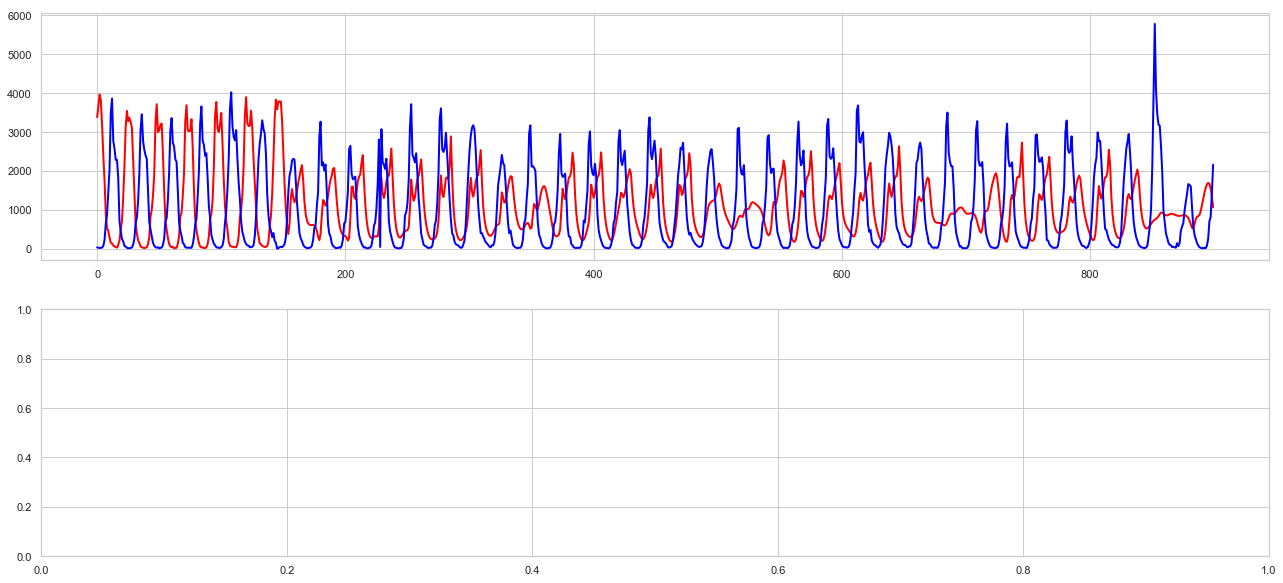

In [456]:
models = [2, 3, 4, 10, 13, 17, 22, 29, 35, 43, 47, 49, 52, 58, 59, 104, 109, 110]
id = 2
%matplotlib inline
fig, axs = plt.subplots(nrows=2, figsize=(22, 10))
sns.set(style="whitegrid")

pred = f3[f3['sensor_id']==id]['hourly_counts']

actual = feb[feb['sensor_id']==id]['hourly_counts']


sns.lineplot(data=pred.reset_index(drop=True).iloc[0:900,], palette="tab10", linewidth=2, ax=axs[0], color = 'red')
sns.lineplot(data=actual.reset_index(drop=True).iloc[0:900], palette="tab10", linewidth=2, ax=axs[0], color = 'blue')



In [446]:
f3 = pd.read_csv('pedestrian/future3mons.csv')
# Find weekday
f3['date_time'] = pd.to_datetime(f3['date_time'], format="%d/%m/%Y %H:%M")

my_day_list = []
for i in range(len(f3)):
    my_date = f3['date_time'][i]
    my_day = calendar.day_name[my_date.weekday()]
    my_day_list.append(my_day)

# Append Column
f3['Day'] = my_day_list

,date_time,hourly_counts,sensor_id,Unnamed: 3,Day
0,2019-04-01 00:00:00,306.0,1,NaN,Monday
1,2019-04-01 01:00:00,199.0,1,NaN,Monday
2,2019-04-01 02:00:00,91.0,1,NaN,Monday
3,2019-04-01 03:00:00,104.0,1,NaN,Monday
4,2019-04-01 04:00:00,42.0,1,NaN,Monday


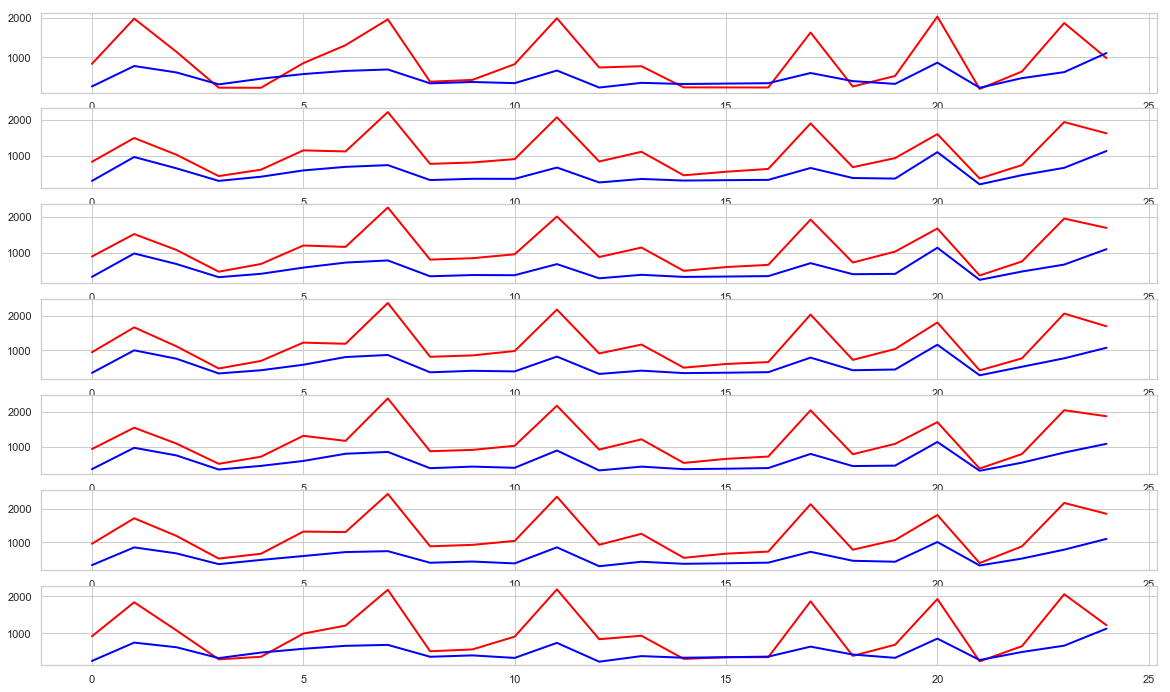

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
fig, axs = plt.subplots(nrows=7, figsize=(20, 12))
sns.set(style="whitegrid")
sns.lineplot(data=p.iloc[:,3], palette="tab10", linewidth=2, ax=axs[0], color = 'red')
sns.lineplot(data=past.iloc[:,4], palette="tab10", linewidth=2, ax=axs[0], color = 'blue')

sns.lineplot(data=p.iloc[:,4], palette="tab10", linewidth=2, ax=axs[1], color = 'red')
sns.lineplot(data=past.iloc[:,5], palette="tab10", linewidth=2, ax=axs[1], color = 'blue')

sns.lineplot(data=p.iloc[:,5], palette="tab10", linewidth=2, ax=axs[2], color = 'red')
sns.lineplot(data=past.iloc[:,6], palette="tab10", linewidth=2, ax=axs[2], color = 'blue')

sns.lineplot(data=p.iloc[:,6], palette="tab10", linewidth=2, ax=axs[3], color = 'red')
sns.lineplot(data=past.iloc[:,7], palette="tab10", linewidth=2, ax=axs[3], color = 'blue')

sns.lineplot(data=p.iloc[:,7], palette="tab10", linewidth=2, ax=axs[4], color = 'red')
sns.lineplot(data=past.iloc[:,8], palette="tab10", linewidth=2, ax=axs[4], color = 'blue')

sns.lineplot(data=p.iloc[:,8], palette="tab10", linewidth=2, ax=axs[5], color = 'red')
sns.lineplot(data=past.iloc[:,9], palette="tab10", linewidth=2, ax=axs[5], color = 'blue')

sns.lineplot(data=p.iloc[:,9], palette="tab10", linewidth=2, ax=axs[6], color = 'red')
sns.lineplot(data=past.iloc[:,10], palette="tab10", linewidth=2, ax=axs[6], color = 'blue')

## <font color='red'>Future - 4 week </font>

In [765]:
nweek = 5
dat = pd.DataFrame()
i = 0

while i < len(s_list):
    # Find Nearest 1 model
    gallery_sensor = pd.DataFrame([{'Latitude':df2['latitude'][i], 'Longitude': df2['longitude'][i]}])
    df_temp = pd.concat([pd.DataFrame(within(gallery_sensor, models_df, 3, 0)).reset_index(drop=True),
               pd.DataFrame(within_d(gallery_sensor, models_df, 3, 0)).reset_index(drop=True)], axis=1)
    df_temp.rename(columns={0:'distance'}, inplace=True)
    df_temp = df_temp.sort_values('distance').iloc[0:1,]
    df_temp = df_temp.reset_index(drop=True)

    df_use = df[df['sensor_id']==s_list[i]].iloc[:,[0,1]]    
    print("Sensor:", s_list[i])

    ad = additional_preds(5, df_use, model=my_models[int(df_temp['sensor_id'])])
    t = pd.DataFrame()
    t = ad[-168*4:].reset_index(drop=True) # 24 hrs * 7 days * 4 weeks
    t['sensor_id'] = s_list[i]
    t.rename(columns={0:'hourly_counts'}, inplace=True)

    dat = pd.concat([dat, t], sort=True)
    
    i += 1

Sensor: 1
Sensor: 2
Sensor: 4
Sensor: 5
Sensor: 6
Sensor: 8
Sensor: 9
Sensor: 10
Sensor: 11
Sensor: 12
Sensor: 14
Sensor: 17
Sensor: 18
Sensor: 19
Sensor: 20
Sensor: 21
Sensor: 22
Sensor: 23
Sensor: 24
Sensor: 25
Sensor: 26
Sensor: 27
Sensor: 28
Sensor: 29
Sensor: 30
Sensor: 31
Sensor: 33
Sensor: 34
Sensor: 35
Sensor: 36
Sensor: 37
Sensor: 39
Sensor: 40
Sensor: 42
Sensor: 43
Sensor: 44
Sensor: 46
Sensor: 47
Sensor: 48
Sensor: 49
Sensor: 50
Sensor: 51
Sensor: 52
Sensor: 53
Sensor: 54
Sensor: 56
Sensor: 57
Sensor: 58
Sensor: 59
Sensor: 101
Sensor: 102
Sensor: 13
Sensor: 103
Sensor: 104
Sensor: 105
Sensor: 106
Sensor: 107
Sensor: 108
Sensor: 109
Sensor: 110


In [798]:
len(dat['sensor_id'].unique())

60

In [767]:
dat2 = dat.merge(df2.iloc[:,1:4], on='sensor_id')

In [772]:
# save and add date time manually
dat2.to_csv('dat2_4.csv', index=False)

In [823]:
# Read back!!
dat2 = pd.read_csv('dat2_4.csv')

In [824]:
# Find weekday
dat2['date_time'] = pd.to_datetime(dat2['date_time'], format="%d/%m/%Y %H:%M")
dat2 = dat2[:40320]

In [825]:
my_day_list = []
for i in range(len(dat2)):
    my_date = dat2['date_time'][i]
    my_day = calendar.day_name[my_date.weekday()]
    my_day_list.append(my_day)

In [826]:
# Append Column
dat2['Day'] = my_day_list

In [827]:
dat2.head(2)

,date_time,hourly_counts,sensor_id,latitude,longitude,Day
0,2019-03-31 23:00:00,0.0,1.0,-37.813494,144.965153,Sunday
1,2019-04-01 00:00:00,0.0,1.0,-37.813494,144.965153,Monday


In [828]:
# Find average for each gallery
average_list = []

for n in range(0,len(gallery)):
    average = for_eachday(get_ped(gallery, dat2, df2, i=n), df2)
    average_list.append(average)
    
# Concat
past4 = pd.concat([gallery, pd.DataFrame(average_list, columns=day_list)], axis=1)
past4

,Gallery Name,Latitude,Longitude,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,Old Melbourne Gaol Crime,-37.807764,144.965464,824,764,670,647,651,649,720
1,Victorian Arts Centre,-37.821995,144.968837,3085,2997,2941,3084,3160,3015,2899
2,The Ian Potter Centre: NGV Australia,-37.817483,144.969899,2300,2253,2221,2341,2418,2312,2214
3,Thoroughbred Racing Gallery,-37.818866,144.983970,600,434,741,995,1049,970,836
4,Fox Classic Car Collection,-37.821374,144.948497,662,751,795,822,846,857,744
5,Koorie Heritage Trust Inc,-37.813385,144.954028,917,886,897,936,948,943,884
6,Australian Centre For The Moving Image (ACMI),-37.817611,144.969070,2100,2070,2055,2174,2248,2149,2047
7,Blindside Gallery,-37.816711,144.966812,2742,2754,2793,2911,2991,2955,2827
8,Flinders Lane Gallery,-37.815715,144.970033,2005,2045,2134,2276,2362,2314,2161
9,Mailbox Art Space,-37.815758,144.969861,1954,1982,2072,2219,2307,2263,2113


In [829]:
past4.to_csv('next_4week.csv')

In [700]:
p = pd.read_csv('past.csv')
p = p.iloc[:,1:]

In [831]:
p

,Gallery Name,Latitude,Longitude,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
0,Old Melbourne Gaol Crime,-37.807764,144.965464,569.0,945.0,850.0,1017.0,758.0,903.0,796.0
1,Victorian Arts Centre,-37.821995,144.968837,2345.0,1572.0,1835.0,1672.0,1897.0,1884.0,2012.0
2,The Ian Potter Centre: NGV Australia,-37.817483,144.969899,658.0,785.0,810.0,806.0,867.0,923.0,583.0
3,Thoroughbred Racing Gallery,-37.818866,144.983970,202.0,598.0,538.0,636.0,576.0,740.0,317.0
4,Fox Classic Car Collection,-37.821374,144.948497,158.0,754.0,671.0,785.0,692.0,876.0,335.0
5,Koorie Heritage Trust Inc,-37.813385,144.954028,602.0,1034.0,1003.0,1077.0,1017.0,1152.0,777.0
6,Australian Centre For The Moving Image (ACMI),-37.817611,144.969070,1289.0,1386.0,1439.0,1445.0,1506.0,1703.0,1323.0
7,Blindside Gallery,-37.816711,144.966812,2130.0,2602.0,2641.0,2704.0,2624.0,2844.0,2519.0
8,Flinders Lane Gallery,-37.815715,144.970033,1613.0,2011.0,2066.0,2076.0,2043.0,2258.0,1964.0
9,Mailbox Art Space,-37.815758,144.969861,1557.0,1961.0,2011.0,2024.0,1990.0,2202.0,1900.0


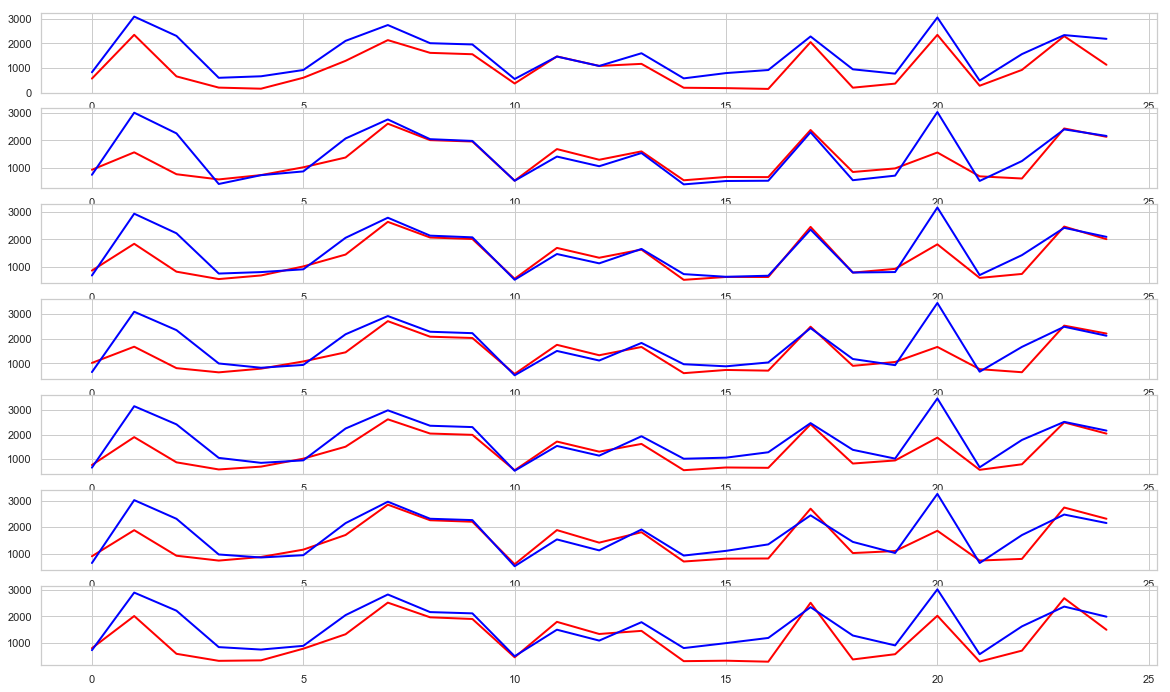

In [830]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
fig, axs = plt.subplots(nrows=7, figsize=(20, 12))
sns.set(style="whitegrid")
sns.lineplot(data=p.iloc[:,3], palette="tab10", linewidth=2, ax=axs[0], color = 'red')
sns.lineplot(data=past4.iloc[:,3], palette="tab10", linewidth=2, ax=axs[0], color = 'blue')

sns.lineplot(data=p.iloc[:,4], palette="tab10", linewidth=2, ax=axs[1], color = 'red')
sns.lineplot(data=past4.iloc[:,4], palette="tab10", linewidth=2, ax=axs[1], color = 'blue')

sns.lineplot(data=p.iloc[:,5], palette="tab10", linewidth=2, ax=axs[2], color = 'red')
sns.lineplot(data=past4.iloc[:,5], palette="tab10", linewidth=2, ax=axs[2], color = 'blue')

sns.lineplot(data=p.iloc[:,6], palette="tab10", linewidth=2, ax=axs[3], color = 'red')
sns.lineplot(data=past4.iloc[:,6], palette="tab10", linewidth=2, ax=axs[3], color = 'blue')

sns.lineplot(data=p.iloc[:,7], palette="tab10", linewidth=2, ax=axs[4], color = 'red')
sns.lineplot(data=past4.iloc[:,7], palette="tab10", linewidth=2, ax=axs[4], color = 'blue')

sns.lineplot(data=p.iloc[:,8], palette="tab10", linewidth=2, ax=axs[5], color = 'red')
sns.lineplot(data=past4.iloc[:,8], palette="tab10", linewidth=2, ax=axs[5], color = 'blue')

sns.lineplot(data=p.iloc[:,9], palette="tab10", linewidth=2, ax=axs[6], color = 'red')
sns.lineplot(data=past4.iloc[:,9], palette="tab10", linewidth=2, ax=axs[6], color = 'blue')

Might need model for Location [1, 2, 15, 20]